In [ ]:
pip install pysal geopandas matplotlib


In [ ]:
import math
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import folium
from folium import Map, Marker, CircleMarker
from folium.plugins import FloatImage

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import euclidean, cosine
from scipy.stats import pearsonr

from splot.esda import lisa_cluster
from libpysal.weights import Queen
from esda import Moran_Local
import geopandas as gpd
import pandas as pd
from splot.esda import plot_local_autocorrelation


## Manipulação do dataframe

In [ ]:


def extractTipologia(sheets, tipo):
  # Lista de tipologias
  tipologias = ['12', '35', '610', '1120', '2150', '51100', '101200', '201500', '5011000', '1001', '0']

  # Criar um DataFrame para armazenar os resultados
  resultados = []
  # Iterar sobre as planilhas das tipologias
  for tipologia in tipologias:
      # Carregar as planilhas Total, NF e F
      df = sheets.parse(f"{tipologia} {tipo}").replace("X", -1)

      # Iterar sobre as linhas do DataFrame
      for idx, row in df.iterrows():
          municipio = row['Município']
          valor = row["Número de estabelecimentos agropecuários com bovinos (Unidades)"]

          # Salvar o maior valor encontrado e a tipologia correspondente
          resultados.append({"Município": municipio, f"Tipologia {tipo}": tipologia, f"Valor {tipo}": valor})

  # Converter resultados para um DataFrame
  df_resultados = pd.DataFrame(resultados)
  df_resultados.sort_values(by="Município", ascending=True, inplace=True)

  # Determinar a maior tipologia por município
  return df_resultados.loc[df_resultados.groupby("Município")[f"Valor {tipo}"].idxmax()]

In [ ]:
# Carregar o arquivo Excel
file_path = "base_de_dados.xlsx"
sheets = pd.ExcelFile(file_path)

df_total = extractTipologia(sheets, "Total")
df_total.reset_index(drop=True, inplace=True)
df_total.head()

<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = sheets.parse(f"{tipologia} {tipo}").replace("X", -1)
<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = sheets.parse(f"{tipologia} {tipo}").replace("X", -1)
<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, se

,Município,Tipologia Total,Valor Total
0,Afonso Cunha (MA),610,12
1,Alcântara (MA),12,531
2,Aldeias Altas (MA),35,66
3,Altamira do Maranhão (MA),2150,84
4,Alto Alegre do Maranhão (MA),610,28


In [ ]:
df_NF = extractTipologia(sheets, "NF")
df_NF.reset_index(drop=True, inplace=True)
df_NF.head()

<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = sheets.parse(f"{tipologia} {tipo}").replace("X", -1)
<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = sheets.parse(f"{tipologia} {tipo}").replace("X", -1)
<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, se

,Município,Tipologia NF,Valor NF
0,Afonso Cunha (MA),51100,1
1,Alcântara (MA),12,28
2,Aldeias Altas (MA),35,11
3,Altamira do Maranhão (MA),201500,16
4,Alto Alegre do Maranhão (MA),51100,6


In [ ]:
df_F = extractTipologia(sheets, "F")
df_F.reset_index(drop=True, inplace=True)
df_F.head()

<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = sheets.parse(f"{tipologia} {tipo}").replace("X", -1)
<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = sheets.parse(f"{tipologia} {tipo}").replace("X", -1)
<ipython-input-85-126d861efd76>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, se

,Município,Tipologia F,Valor F
0,Afonso Cunha (MA),610,11
1,Alcântara (MA),12,503
2,Aldeias Altas (MA),610,56
3,Altamira do Maranhão (MA),2150,73
4,Alto Alegre do Maranhão (MA),610,24


In [ ]:
# 2. Substituir valores 'X' por 0 e garantir que os dados sejam numéricos
def tratar_dados(df):
    df = df.replace("X", 0)  # Substituir 'X' por 0
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)  # Garantir que sejam numéricos
    return df


In [ ]:
tipologias = ['12', '35', '610', '1120', '2150', '51100', '101200', '201500', '5011000', '1001', '0']

# Criar um DataFrame para armazenar os resultados
dados = pd.DataFrame()
df_total = sheets.parse("Total")
df_total = tratar_dados(df_total)
dados["Minicípio"] = df_total["Município"]
# Iterar sobre as planilhas das tipologias
for tipologia in tipologias:
  # Carregar as planilhas Total, NF e F
  df = sheets.parse(f"{tipologia} Total")
  # Obter os dados da coluna de interesse
  column_data = df["Número de estabelecimentos agropecuários com bovinos (Unidades)"]
  dados[f"{tipologia}"] = column_data

total_estabelecimentos = dados

<ipython-input-89-36b8f700e8c9>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("X", 0)  # Substituir 'X' por 0


In [ ]:
tipologias = ['12', '35', '610', '1120', '2150', '51100', '101200', '201500', '5011000', '1001', '0']

# Criar um DataFrame para armazenar os resultados
dados = pd.DataFrame()
df_total = sheets.parse("Total")
df_total = tratar_dados(df_total)
dados["Minicípio"] = df_total["Município"]
# Iterar sobre as planilhas das tipologias
for tipologia in tipologias:
  # Carregar as planilhas Total, NF e F
  df = sheets.parse(f"{tipologia} F")
  # Obter os dados da coluna de interesse
  column_data = df["Número de estabelecimentos agropecuários com bovinos (Unidades)"]
  dados[f"{tipologia}"] = column_data

familiar_estabelecimentos = dados

<ipython-input-89-36b8f700e8c9>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("X", 0)  # Substituir 'X' por 0


In [ ]:
def maiores_contribuicoes(vetor_geral, vetor_familiar):
    # Calcular as diferenças ao quadrado e o total
    diferencas_quadradas = [(i, (g - f) ** 2) for i, (g, f) in enumerate(zip(vetor_geral, vetor_familiar))]
    soma_total = sum([dif[1] for dif in diferencas_quadradas])

    # Se a soma total for zero, evitar divisão por zero
    if soma_total == 0:
        return {indice: 0.0 for indice, _ in diferencas_quadradas[:10]}

    # Calcular a porcentagem de contribuição
    maiores_com_percentual = {indice: round((valor / soma_total) * 100, 2) for indice, valor in diferencas_quadradas}
    return maiores_com_percentual

In [ ]:
# 4. Criar vetores para cada município
resultados = []

for i, municipio in enumerate(total_estabelecimentos.iloc[:, 0]):  # Iterar pelos municípios
    vetor_total = total_estabelecimentos.iloc[i, 1:].values  # Vetor da planilha 'Total'
    vetor_total_f = familiar_estabelecimentos.iloc[i, 1:].values  # Vetor da planilha 'Total F'

    # Cálculos das métricas
    distancia_euclidiana = euclidean(vetor_total, vetor_total_f)
    # similaridade_coseno = calcular_similaridade_coseno(vetor_total, vetor_total_f)
    similaridade_coseno = 1 - cosine(vetor_total, vetor_total_f) if not np.all(vetor_total == 0) else 0
    correlacao_pearson = pearsonr(vetor_total, vetor_total_f)[0] if len(set(vetor_total)) > 1 else 0


    # Salvar resultados
    resultados.append({
        "Cidade": municipio,
        "Distância Euclidiana": round(distancia_euclidiana, 2),
        "Similaridade Coseno": round(similaridade_coseno, 2),
        "Correlação Pearson": round(correlacao_pearson, 2)
    })

# 5. Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)

df_contribuicoes = pd.DataFrame()
# Criar a nova coluna com os índices e suas contribuições percentuais
for i, municipio in enumerate(total_estabelecimentos.iloc[:, 0]):
  total = total_estabelecimentos.iloc[i, 1:].values
  familiar = familiar_estabelecimentos.iloc[i, 1:].values
  df_contribuicoes[f"{municipio}"] = maiores_contribuicoes(total, familiar)


<ipython-input-93-4413e3374881>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contribuicoes[f"{municipio}"] = maiores_contribuicoes(total, familiar)
<ipython-input-93-4413e3374881>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contribuicoes[f"{municipio}"] = maiores_contribuicoes(total, familiar)
<ipython-input-93-4413e3374881>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

In [ ]:
df_resultados.sort_values(by="Distância Euclidiana", ascending=False, inplace=True)
df_resultados.reset_index(drop=True, inplace=True)
df_resultados

,Cidade,Distância Euclidiana,Similaridade Coseno,Correlação Pearson
0,Grajaú (MA),204.98,1.00,1.00
1,Açailândia (MA),142.80,0.96,0.94
2,Amarante do Maranhão (MA),119.59,1.00,1.00
3,Matinha (MA),118.10,1.00,1.00
4,Riachão (MA),117.10,0.99,0.99
...,...,...,...,...
212,Presidente Juscelino (MA),2.83,1.00,1.00
213,Afonso Cunha (MA),2.24,1.00,0.99
214,Belágua (MA),2.24,1.00,1.00
215,Duque Bacelar (MA),1.73,1.00,1.00


In [ ]:
df_contribuicoes = df_contribuicoes.transpose()
df_contribuicoes.columns = tipologias
df_contribuicoes

,12,35,610,1120,2150,51100,101200,201500,5011000,1001,0
Açailândia (MA),0.00,0.04,0.12,0.83,7.85,5.34,18.25,46.14,7.08,14.30,0.04
Afonso Cunha (MA),0.00,20.00,20.00,0.00,20.00,20.00,20.00,0.00,0.00,0.00,0.00
Água Doce do Maranhão (MA),13.79,42.24,42.24,0.86,0.86,0.00,0.00,0.00,0.00,0.00,0.00
Alcântara (MA),84.12,12.98,0.97,0.00,0.11,0.11,0.00,0.00,0.00,0.00,1.72
Aldeias Altas (MA),13.69,33.80,10.06,13.69,27.93,0.28,0.28,0.00,0.28,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
Viana (MA),0.31,4.94,25.02,19.77,37.37,2.78,7.72,1.93,0.00,0.08,0.08
Vila Nova dos Martírios (MA),0.16,0.00,0.04,1.46,7.97,4.92,11.75,61.85,4.92,6.87,0.04
Vitória do Mearim (MA),5.98,13.46,7.24,21.60,28.96,17.30,4.85,0.54,0.06,0.00,0.00
Vitorino Freire (MA),0.10,0.75,6.71,11.93,35.23,15.09,17.71,8.49,1.97,1.97,0.05


In [ ]:
principais_municipios = df_resultados["Cidade"][:25]
df_filtrado = df_contribuicoes.loc[principais_municipios]

In [ ]:
with open('geojs-21-mun.json') as f:
    geo_data = json.load(f)

df_resultados['Cidade'] = df_resultados['Cidade'].str.replace(" (MA)", "", regex=False)

# Criar o dicionário de proporções
distancia_dict = pd.Series(df_resultados['Distância Euclidiana'].values.astype('str'), index=df_resultados['Cidade']).to_dict()

# Adicionar o campo da proporção no geojson
for feature in geo_data['features']:
    municipio = feature['properties']['name']
    feature['properties']['distancia'] = distancia_dict.get(f"{municipio}", 'N/A') # Adiciona a proporção ao GeoJSON

# Função para definir o estilo
def get_style(feature):
    return {
        'fillColor': '#FFFFFF',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0
    }

# Criar o mapa base
m = folium.Map(location=[-7, -45], zoom_start=6)

# Criar a camada Choropleth
choropleth = folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=df_resultados,
    columns=["Cidade", "Distância Euclidiana"],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Distância euclidiana',
    highlight=True
).add_to(m)

# Adicionar o GeoJson com o tooltip personalizado
folium.GeoJson(
    geo_data,
    style_function=get_style,  # Aplica o estilo
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "distancia"],  # Agora usamos 'name' e 'pronaf' do GeoJSON
        aliases=["Município: ", "Distância euclidiana: "],  # Legendas para os campos
        localize=True
    )
).add_to(m)

# Exibir o mapa
m

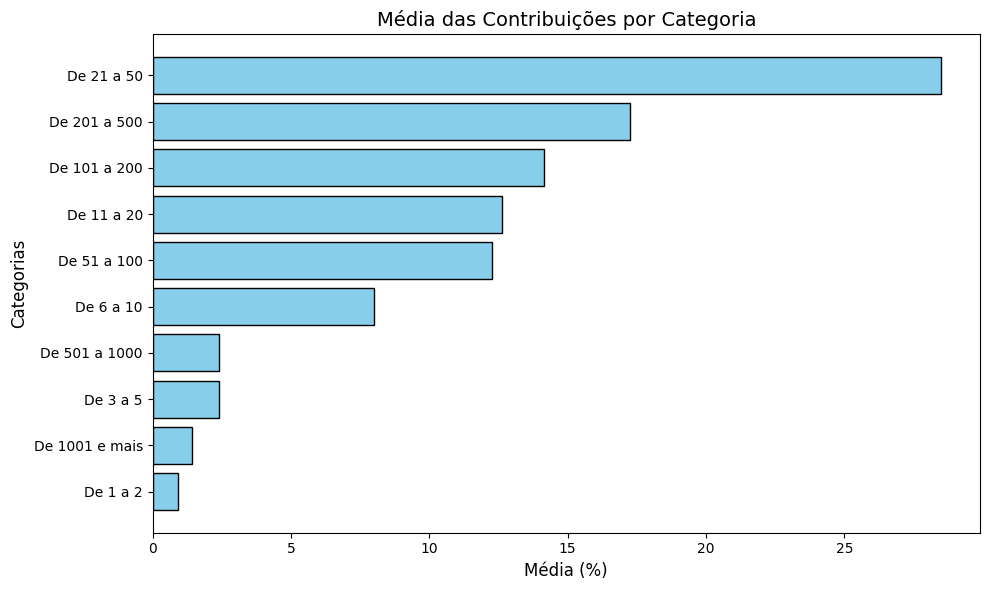

In [ ]:
# Dados das médias das categorias
medias = {
    0: 0.917200,
    1: 2.389200,
    2: 8.004000,
    3: 12.634000,
    4: 28.476800,
    5: 12.275600,
    6: 14.159200,
    7: 17.250400,
    8: 2.41280,
    9: 1.421200
}

# Nomes correspondentes às categorias
nomes_categorias = {
    0: "De 1 a 2",
    1: "De 3 a 5",
    2: "De 6 a 10",
    3: "De 11 a 20",
    4: "De 21 a 50",
    5: "De 51 a 100",
    6: "De 101 a 200",
    7: "De 201 a 500",
    8: "De 501 a 1000",
    9: "De 1001 e mais"
}

# Ordenar as categorias pela média (maior para menor)
categorias_ordenadas = sorted(medias.items(), key=lambda x: x[1], reverse=True)

# Extrair os dados para o gráfico
categorias = [nomes_categorias[cat[0]] for cat in categorias_ordenadas]
valores = [cat[1] for cat in categorias_ordenadas]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(categorias, valores, color='skyblue', edgecolor='black')

# Configurar títulos e rótulos
plt.title('Média das Contribuições por Categoria', fontsize=14)
plt.xlabel('Média (%)', fontsize=12)
plt.ylabel('Categorias', fontsize=12)
plt.gca().invert_yaxis()  # Inverter o eixo Y para exibir a maior média no topo

# Exibir o gráfico
plt.tight_layout()
plt.show()


In [ ]:
def calcular_proporcoes(maiores_contribuicoes):
    soma_total = sum(maiores_contribuicoes.values)
    proporcoes = {categoria: round((valor / soma_total) * 100, 2) for categoria, valor in maiores_contribuicoes.items()} if soma_total > 0 else {}
    return proporcoes

df_proporcoes = pd.DataFrame()
# Criar a nova coluna com os índices e suas contribuições percentuais
for i, municipio in enumerate(total_estabelecimentos.iloc[:, 0]):
  total = df_contribuicoes.loc[municipio]
  df_proporcoes[f"{municipio}"] = calcular_proporcoes(total)


<ipython-input-99-567431a9a170>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_proporcoes[f"{municipio}"] = calcular_proporcoes(total)
<ipython-input-99-567431a9a170>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_proporcoes[f"{municipio}"] = calcular_proporcoes(total)
<ipython-input-99-567431a9a170>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

In [ ]:
df_proporcoes = df_proporcoes.transpose()

In [ ]:
df_proporcoes['Categoria Dominante'] = df_proporcoes.idxmax(axis=1)

In [ ]:
def calcular_proporcoes_familiares_todas_cidades(df_total, df_familiar):
    # Lista para armazenar os dados de todas as cidades
    proporcoes_dados = []

    for i, municipio in enumerate(df_total.iloc[:, 0]):
      valores_total = df_total.iloc[i, 1:].values
      valores_familiar = df_familiar.iloc[i, 1:].values
      porcao_familiar = (valores_familiar / valores_total) * 100

      proporcoes_dict = {'Cidade': municipio}
      for i, label in enumerate(tipologias):
          proporcoes_dict[label] = porcao_familiar[i]

      proporcoes_dados.append(proporcoes_dict)

    porcao_familiar = pd.DataFrame(proporcoes_dados)
    return porcao_familiar

In [ ]:
# Exemplo de uso
# Substitua `df_estabelecimentos` pelo seu DataFrame e `lista_cidades` pela lista de cidades desejada
porcao_familiar = calcular_proporcoes_familiares_todas_cidades(total_estabelecimentos, familiar_estabelecimentos)

porcao_familiar = porcao_familiar.fillna(0).mean(numeric_only=True).round(2).rename("Agricultura familiar")
porcao_familiar = porcao_familiar.apply(lambda x: f"{x:.2f}%")

# Exibe o DataFrame
porcao_familiar

<ipython-input-102-e3dbd43332d8>:8: RuntimeWarning: invalid value encountered in scalar divide
  porcao_familiar = (valores_familiar / valores_total) * 100
<ipython-input-102-e3dbd43332d8>:8: RuntimeWarning: invalid value encountered in divide
  porcao_familiar = (valores_familiar / valores_total) * 100


,Agricultura familiar
12,82.16%
35,87.84%
610,87.35%
1120,85.28%
2150,81.78%
51100,66.06%
101200,42.97%
201500,14.17%
5011000,1.55%
1001,0.09%


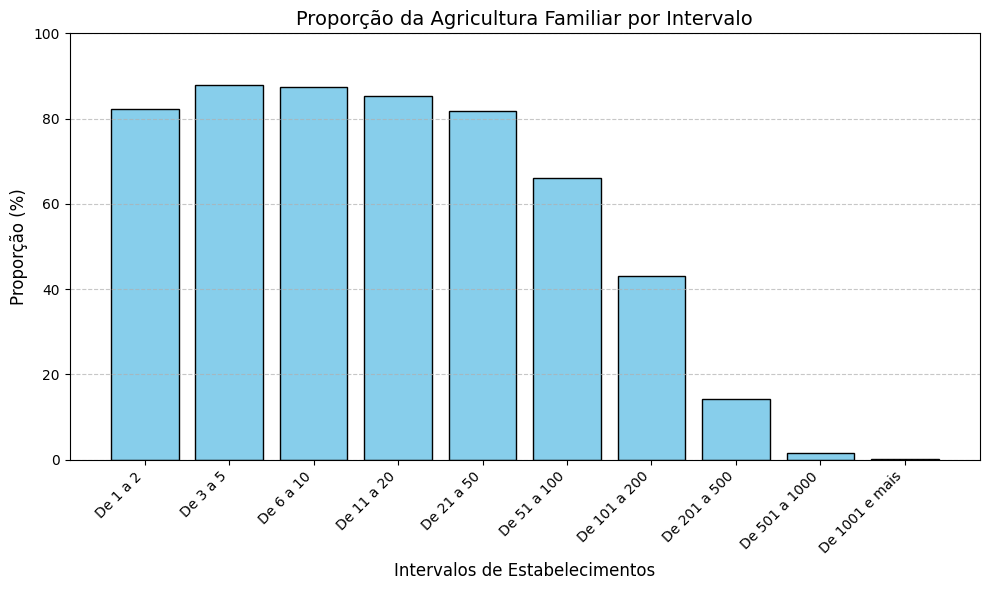

In [ ]:
intervalos = [
    "De 1 a 2", "De 3 a 5", "De 6 a 10", "De 11 a 20",
    "De 21 a 50", "De 51 a 100", "De 101 a 200",
    "De 201 a 500", "De 501 a 1000", "De 1001 e mais"
]

valores = [82.16, 87.84, 87.35, 85.28, 81.78, 66.06, 42.97, 14.17, 1.55, 0.09]

# Criar o histograma
plt.figure(figsize=(10, 6))
plt.bar(intervalos, valores, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Proporção da Agricultura Familiar por Intervalo', fontsize=14)
plt.xlabel('Intervalos de Estabelecimentos', fontsize=12)
plt.ylabel('Proporção (%)', fontsize=12)
plt.ylim(0, 100)  # Proporção varia de 0 a 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o histograma
plt.tight_layout()
plt.show()

In [ ]:
def calcular_proporcoes_familiares_todas_cidades(df_total, df_familiar):
    # Lista para armazenar os dados de todas as cidades
    proporcoes_dados = []

    for i, municipio in enumerate(df_total.iloc[:, 0]):
      valores_total = df_total.iloc[i, 1:].values
      valores_familiar = df_familiar.iloc[i, 1:].values
      porcao_familiar = (valores_familiar / valores_total) * 100

      proporcoes_dict = {'Cidade': municipio}
      for i, label in enumerate(tipologias):
          proporcoes_dict[label] = porcao_familiar[i]

      proporcoes_dados.append(proporcoes_dict)

    porcao_familiar = pd.DataFrame(proporcoes_dados)
    return porcao_familiar



In [ ]:
# 1. Carregar as planilhas
total_df = pd.read_excel(sheets, sheet_name="Total")
total_f_df = pd.read_excel(sheets, sheet_name="Total F")

total_df = tratar_dados(total_df)
total_f_df = tratar_dados(total_f_df)

#----------------------------------------------------------------#

# Excluindo a coluna 'Município' para análise PCA
total_values = total_df.drop(columns=['Município']).values
total_f_values = total_f_df.drop(columns=['Município']).values

# Padronizar os dados (o PCA funciona melhor se os dados estiverem normalizados)
scaler = StandardScaler()
total_scaled = scaler.fit_transform(total_values)

## Aplicar o PCA
n_components = 5
pca = PCA(n_components=n_components)  # Usando 2 componentes principais (primeiro e segundo)
pca.fit(total_scaled)

# A variância explicada por cada componente
variancia_explicada = pca.explained_variance_ratio_

# A contribuição de cada variável para os componentes principais
componentes = pca.components_

# Exibindo as contribuições das variáveis para o primeiro componente principal
# As contribuições de cada variável para o primeiro componente principal
contribuicoes_primeiro_componente = componentes[0]

# Identificar as 3 variáveis com as maiores contribuições para o primeiro componente

# Ordenar as variáveis pela magnitude das contribuições (absoluta)
importancia = np.abs(contribuicoes_primeiro_componente)
indices_importantes = np.argsort(importancia)[::-1]  # Ordenar em ordem decrescente

# As n variáveis mais importantes
n = 19
top_variaveis = ['Município'] + total_df.columns[indices_importantes[:n]+1].tolist() # Adicionando 1 para ignorar a coluna 'Município'
print(f"Top {n} variáveis mais importantes:", top_variaveis)

#----------------------------------------------------------------#

df_reduzido_total = total_df[top_variaveis]
df_reduzido_familiar = total_f_df[top_variaveis]

df_reduzido_total['Município'] = df_reduzido_total['Município'].str.replace(" (MA)", "", regex=False)
df_reduzido_familiar['Município'] = df_reduzido_familiar['Município'].str.replace(" (MA)", "", regex=False)


<ipython-input-89-36b8f700e8c9>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("X", 0)  # Substituir 'X' por 0


Top 19 variáveis mais importantes: ['Município', 'Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos (Unidades)', 'Número de cabeças de vacas reprodutoras (2 anos e mais) nos estabelecimentos agropecuários (Cabeças)', 'Número de cabeças de bovinos nos estabelecimentos agropecuários (Cabeças)', 'Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos que venderam bovinos para abate (Unidades)', 'Número de cabeças de bovinos nos estabelecimentos agropecuários com mais de 50 cabeças de bovinos (Cabeças)', 'Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos que venderam bovinos para cria, recria ou engorda (Unidades)', 'Número de cabeças de bovinos para cria, recria ou engorda vendidas nos estabelecimentos agropecuários com mais de 50 cabeças (Cabeças)', 'Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos que venderam matrizes e reprodutores de bovinos (Unidades)', 'Número de cabeças de bovinos vendi

In [ ]:
df_reduzido_total

,Município,Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos (Unidades),Número de cabeças de vacas reprodutoras (2 anos e mais) nos estabelecimentos agropecuários (Cabeças),Número de cabeças de bovinos nos estabelecimentos agropecuários (Cabeças),Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos que venderam bovinos para abate (Unidades),Número de cabeças de bovinos nos estabelecimentos agropecuários com mais de 50 cabeças de bovinos (Cabeças),"Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos que venderam bovinos para cria, recria ou engorda (Unidades)","Número de cabeças de bovinos para cria, recria ou engorda vendidas nos estabelecimentos agropecuários com mais de 50 cabeças (Cabeças)",Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos que venderam matrizes e reprodutores de bovinos (Unidades),Número de cabeças de bovinos vendidas nos estabelecimentos agropecuários com 50 cabeças e menos (Cabeças),Número de cabeças de bovinos nos estabelecimentos agropecuários com 50 cabeças e menos (Cabeças),"Valor da venda de cabeças de bovinos para cria, recria ou engorda nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)",Valor da venda de cabeças de bovinos nos estabelecimentos agropecuários com 50 cabeças e menos (Mil Reais),Número de estabelecimentos agropecuários com bovinos (Unidades),Número de estabelecimentos agropecuários com 50 cabeças e menos de bovinos que venderam bovinos (Unidades),Número de cabeças de matrizes e reprodutores de bovinos vendidas nos estabelecimentos agropecuários com mais de 50 cabeças (Cabeças),Valor da venda de cabeças de matrizes e reprodutores de bovinos nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais),Número de cabeças de bovinos para abate vendidas nos estabelecimentos agropecuários com mais de 50 cabeças (Cabeças),Valor da venda de cabeças de bovinos para abate nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais),Número de estabelecimentos agropecuários com 50 cabeças e menos de bovinos (Unidades)
0,Açailândia,615,58799,261982,341,250567,294,20210,115,3577,11415,20274,3924.05,1061,292,5580,12031.62,46773,89018.07,446
1,Afonso Cunha,3,251,730,2,263,2,0,1,39,467,0,45.36,48,8,0,0.00,0,0.00,45
2,Água Doce do Maranhão,0,443,1692,0,0,0,0,0,294,1692,0,393.84,230,102,0,0.00,0,0.00,230
3,Alcântara,3,379,2199,0,302,1,0,0,477,1897,0,951.46,792,253,0,0.00,0,0.00,789
4,Aldeias Altas,7,1228,3938,3,1090,0,0,1,205,2848,0,264.28,245,71,0,0.00,26,31.20,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Viana,35,3398,14189,25,6175,6,894,5,2831,8014,655,3550.74,658,436,98,216.43,1380,2187.12,623
213,Vila Nova dos Martírios,201,18345,67817,109,63521,71,3300,13,1257,4296,3366,1436.73,346,90,274,489.66,9275,15691.00,145
214,Vitória do Mearim,79,6565,15537,55,9404,32,672,18,1074,6133,496,1046.71,529,245,319,430.84,886,1156.04,450
215,Vitorino Freire,223,22942,66724,143,57343,84,3094,15,2200,9381,2788,2429.98,669,301,270,528.83,8428,14707.78,446


## Correlações


In [ ]:
# Carregar dados geográficos
geo_data = gpd.read_file("geojs-21-mun.json")


# Mesclar os dados
merged_data = geo_data.merge(df_reduzido_total, left_on="name", right_on="Município")  # Substitua pela coluna correta


In [ ]:
merged_data

,id,name,description,geometry,Município,Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos (Unidades),Número de cabeças de vacas reprodutoras (2 anos e mais) nos estabelecimentos agropecuários (Cabeças),Número de cabeças de bovinos nos estabelecimentos agropecuários (Cabeças),Número de estabelecimentos agropecuários com mais de 50 cabeças de bovinos que venderam bovinos para abate (Unidades),Número de cabeças de bovinos nos estabelecimentos agropecuários com mais de 50 cabeças de bovinos (Cabeças),...,Número de cabeças de bovinos nos estabelecimentos agropecuários com 50 cabeças e menos (Cabeças),"Valor da venda de cabeças de bovinos para cria, recria ou engorda nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)",Valor da venda de cabeças de bovinos nos estabelecimentos agropecuários com 50 cabeças e menos (Mil Reais),Número de estabelecimentos agropecuários com bovinos (Unidades),Número de estabelecimentos agropecuários com 50 cabeças e menos de bovinos que venderam bovinos (Unidades),Número de cabeças de matrizes e reprodutores de bovinos vendidas nos estabelecimentos agropecuários com mais de 50 cabeças (Cabeças),Valor da venda de cabeças de matrizes e reprodutores de bovinos nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais),Número de cabeças de bovinos para abate vendidas nos estabelecimentos agropecuários com mais de 50 cabeças (Cabeças),Valor da venda de cabeças de bovinos para abate nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais),Número de estabelecimentos agropecuários com 50 cabeças e menos de bovinos (Unidades)
0,2100055,Açailândia,Açailândia,"POLYGON ((-47.01661 -4.41956, -46.99895 -4.426...",Açailândia,615,58799,261982,341,250567,...,11415,20274,3924.05,1061,292,5580,12031.62,46773,89018.07,446
1,2100105,Afonso Cunha,Afonso Cunha,"POLYGON ((-43.25227 -4.09112, -43.24397 -4.116...",Afonso Cunha,3,251,730,2,263,...,467,0,45.36,48,8,0,0.00,0,0.00,45
2,2100154,Água Doce do Maranhão,Água Doce do Maranhão,"POLYGON ((-42.08106 -2.80004, -42.07141 -2.812...",Água Doce do Maranhão,0,443,1692,0,0,...,1692,0,393.84,230,102,0,0.00,0,0.00,230
3,2100204,Alcântara,Alcântara,"POLYGON ((-44.44867 -2.13069, -44.45121 -2.133...",Alcântara,3,379,2199,0,302,...,1897,0,951.46,792,253,0,0.00,0,0.00,789
4,2100303,Aldeias Altas,Aldeias Altas,"POLYGON ((-43.10642 -4.48175, -43.11555 -4.500...",Aldeias Altas,7,1228,3938,3,1090,...,2848,0,264.28,245,71,0,0.00,26,31.20,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2112803,Viana,Viana,"POLYGON ((-45.12056 -2.9299, -45.11946 -2.9361...",Viana,35,3398,14189,25,6175,...,8014,655,3550.74,658,436,98,216.43,1380,2187.12,623
210,2112852,Vila Nova dos Martírios,Vila Nova dos Martírios,"POLYGON ((-47.98411 -5.04582, -47.98011 -5.053...",Vila Nova dos Martírios,201,18345,67817,109,63521,...,4296,3366,1436.73,346,90,274,489.66,9275,15691.00,145
211,2112902,Vitória do Mearim,Vitória do Mearim,"POLYGON ((-44.86331 -3.34599, -44.83739 -3.424...",Vitória do Mearim,79,6565,15537,55,9404,...,6133,496,1046.71,529,245,319,430.84,886,1156.04,450
212,2113009,Vitorino Freire,Vitorino Freire,"POLYGON ((-45.33582 -3.9028, -45.32645 -3.9055...",Vitorino Freire,223,22942,66724,143,57343,...,9381,2788,2429.98,669,301,270,528.83,8428,14707.78,446


In [ ]:
# Criar matriz de pesos de vizinhança
weights = Queen.from_dataframe(merged_data)

weights.transform = 'r'


<ipython-input-110-82460a1a6530>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(merged_data)


In [ ]:
# Variável para análise (exemplo: produção de leite)
var = merged_data["Valor da venda de cabeças de bovinos para abate nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)"].astype(float).values

# Cálculo de Moran
moran = Moran(var, weights)

print(f"I de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")


I de Moran: 0.5166192170582458
p-value: 0.001


In [ ]:
# Variável para análise (exemplo: produção de leite)
var = merged_data["Valor da venda de cabeças de matrizes e reprodutores de bovinos nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)"].astype(float).values

# Cálculo de Moran
moran = Moran(var, weights)

print(f"I de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")


I de Moran: 0.31926320059481256
p-value: 0.001


In [ ]:
# Variável para análise (exemplo: produção de leite)
var = merged_data["Valor da venda de cabeças de bovinos nos estabelecimentos agropecuários com 50 cabeças e menos (Mil Reais)"].astype(float).values

# Cálculo de Moran
moran = Moran(var, weights)

print(f"I de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")

I de Moran: 0.5165255807111768
p-value: 0.001


In [ ]:
# Variável para análise (exemplo: produção de leite)
var = merged_data["Valor da venda de cabeças de bovinos para cria, recria ou engorda nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)"].astype(float).values

# Cálculo de Moran
moran = Moran(var, weights)

print(f"I de Moran: {moran.I}")
print(f"p-value: {moran.p_sim}")

I de Moran: 0.48618135438213594
p-value: 0.001


(<Figure size 640x480 with 1 Axes>, <Axes: >)

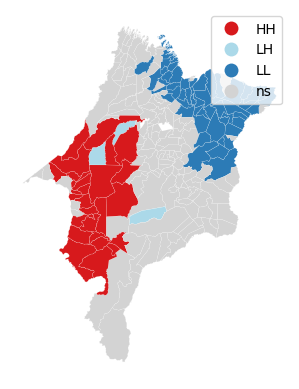

In [ ]:
# Cálculo de Moran Local
moran_local = Moran_Local(var, weights)

# Plotar clusters LISA
lisa_cluster(moran_local, merged_data)


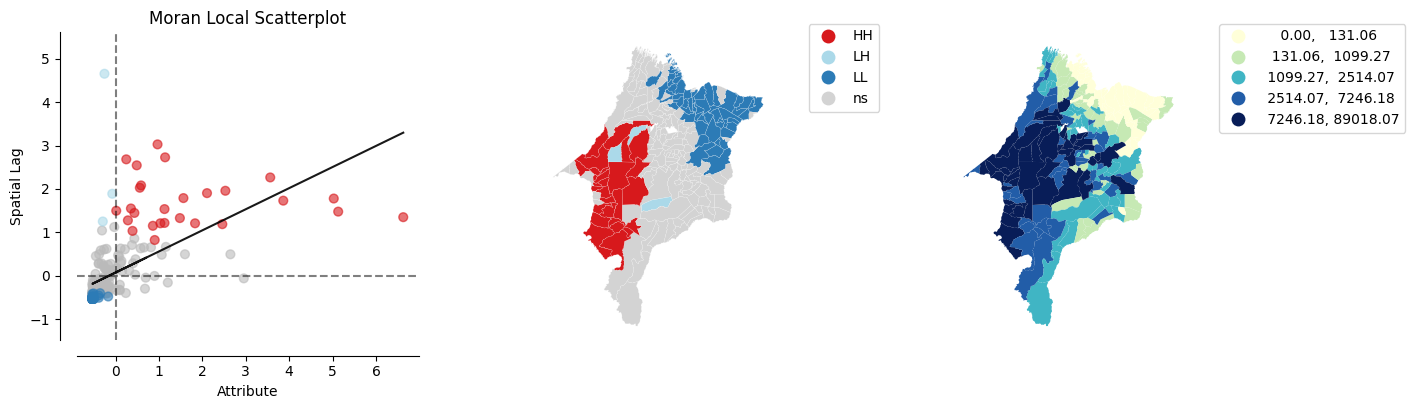

In [ ]:
# Plotar autocorrelação local
plot_local_autocorrelation(moran_local, merged_data, 'Valor da venda de cabeças de bovinos para cria, recria ou engorda nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)')
plt.show()

In [ ]:
rodovias_data = gpd.read_file("rodovias_federais_brasil.json")

# Filtrar apenas as rodovias no Maranhão (sg_uf == "MA")
rodovias_data = rodovias_data[rodovias_data["sg_uf"] == "MA"]



In [ ]:
geo_data = geo_data.to_crs("EPSG:31983")
rodovias_data = rodovias_data.to_crs(geo_data.crs)

<ipython-input-125-642c79fd24e7>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_data)


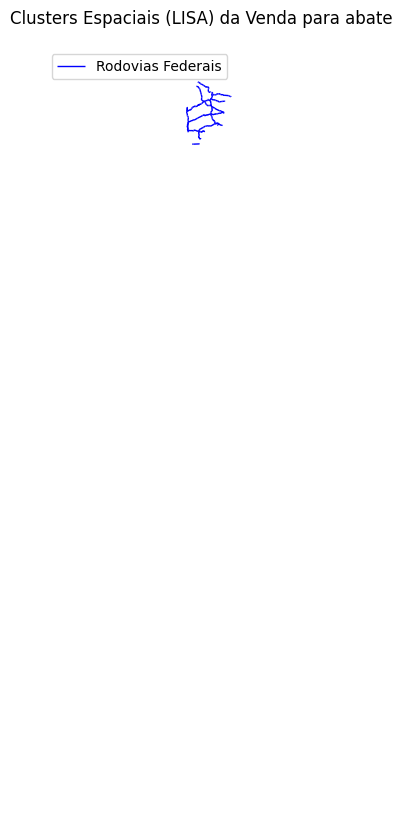

In [ ]:
w = Queen.from_dataframe(merged_data)
w.transform = 'r'

# Calcular LISA
y = merged_data['Valor da venda de cabeças de bovinos para abate nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)'].values
lisa = Moran_Local(y, w)

# Plotar o mapa LISA
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lisa_cluster(lisa, merged_data, ax=ax)
rodovias_data.plot(ax=ax, color='blue', linewidth=1, label="Rodovias Federais")

plt.title("Clusters Espaciais (LISA) da Venda para abate")
plt.legend()
plt.show()


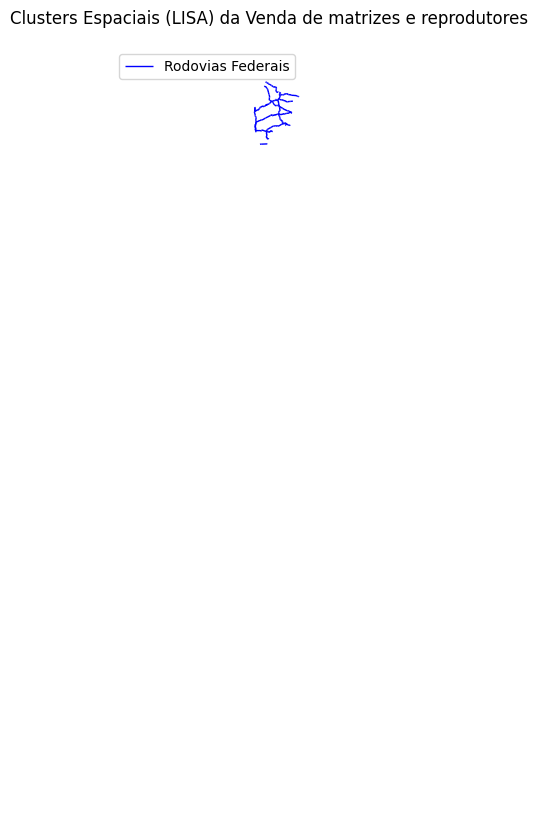

In [ ]:
# Calcular LISA
y = merged_data['Valor da venda de cabeças de matrizes e reprodutores de bovinos nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)'].values
lisa = Moran_Local(y, w)

# Plotar o mapa LISA
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lisa_cluster(lisa, merged_data, ax=ax)
rodovias_data.plot(ax=ax, color='blue', linewidth=1, label="Rodovias Federais")

plt.title("Clusters Espaciais (LISA) da Venda de matrizes e reprodutores")
plt.legend()
plt.show()


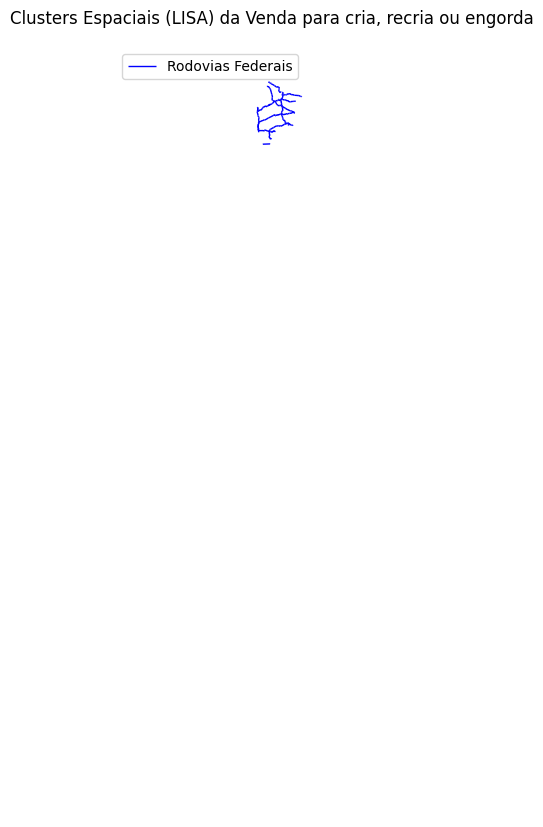

In [ ]:
# Calcular LISA
y = merged_data['Valor da venda de cabeças de bovinos para cria, recria ou engorda nos estabelecimentos agropecuários com mais de 50 cabeças (Mil Reais)'].values
lisa = Moran_Local(y, w)

# Plotar o mapa LISA
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lisa_cluster(lisa, merged_data, ax=ax)
rodovias_data.plot(ax=ax, color='blue', linewidth=1, label="Rodovias Federais")

plt.title("Clusters Espaciais (LISA) da Venda para cria, recria ou engorda")
plt.legend()
plt.show()

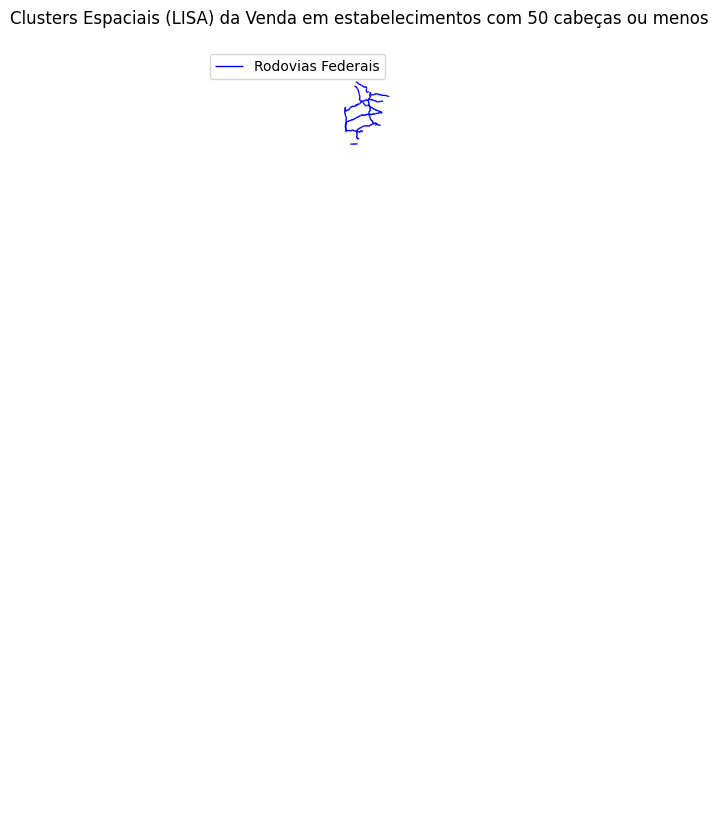

In [ ]:
# Calcular LISA
y = merged_data['Valor da venda de cabeças de bovinos nos estabelecimentos agropecuários com 50 cabeças e menos (Mil Reais)'].values
lisa = Moran_Local(y, w)

# Plotar o mapa LISA
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
lisa_cluster(lisa, merged_data, ax=ax)
rodovias_data.plot(ax=ax, color='blue', linewidth=1, label="Rodovias Federais")

plt.title("Clusters Espaciais (LISA) da Venda em estabelecimentos com 50 cabeças ou menos")
plt.legend()
plt.show()